# Hypothesis Testing, ANOVA and Tukey's post hoc

ANalysis Of VAriance (commonly called ANOVA) is a group of statistical techniques that test the difference of means among three or more groups. It's a powerful tool for determining whether population means are different across groups and for answering a wide range of business questions.

When our categorical variable has two classes, we generally go for T-test to check whether the difference between the means of two classes is statistically significant. But if our categorical variable has 3 or more classes, we perform ANOVA to check whether the differences among the means of all classes is statistically significant. To draw a parallel, 

|     | T-test | ANOVA |
| --- | --- | --- |
| $H_0$ | $\mu_1$ = $\mu_2$ | $\mu_1$ = $\mu_2$ = $\mu_3$ =... |
| $H_A$ | $\mu_1$ $\neq$ $\mu_2$ | $\mu_1$ $\neq$ $\mu_2$ $\neq$ $\mu_3$ $\neq$... |

**Note:** In an ANOVA test, even if one of the pairs have statistical significant unequal means, our Null Hypothesis will be rejected. In case, the null hypothesis gets rejected, we still wouldn't know whether all the pairs of mean were unequal or there was just 1 pair that was unequal. To exactly know which of the pairs of mean were unequal, we need a post hoc ANOVA test.

I will be working on a historical marketing promotion data. I will use the data to run a one-way ANOVA and a post hoc ANOVA test.

To know if sales are significantly different among various TV and influencer promotion types, a one-way ANOVA test will enable us to determine if there is a statistically significant difference in sales among groups. This includes:
* Using plots and descriptive statistics to select a categorical independent variable
* Creating and fitting a linear regression model with the selected categorical independent variable
* Checking model assumptions
* Performing and interpreting a one-way ANOVA test
* Comparing pairs of groups using an ANOVA post hoc test

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
data = pd.read_csv('marketing_sales_data.csv')
data.head()

,TV,Radio,Social Media,Influencer,Sales
0,Low,1.218354,1.270444,Micro,90.054222
1,Medium,14.949791,0.274451,Macro,222.741668
2,Low,10.377258,0.061984,Mega,102.774790
3,High,26.469274,7.070945,Micro,328.239378
4,High,36.876302,7.618605,Mega,351.807328


## Running Descriptive Statistics

In [3]:
data["Influencer"].value_counts()

Mega     148
Nano     148
Micro    145
Macro    131
Name: Influencer, dtype: int64

In [4]:
data["TV"].value_counts()

Low       197
Medium    197
High      177
Name: TV, dtype: int64

The features in the data are:
* TV promotion budget (in Low, Medium, and High categories)
* Social media promotion budget (in millions of dollars)
* Radio promotion budget (in millions of dollars)
* Sales (in millions of dollars)
* Influencer size (in Mega, Macro, Nano, and Micro categories)

## Selcting the right categorical independent variable

First, lets make a boxplot to determine how `Sales` vary based on the `TV` promotion budget category.

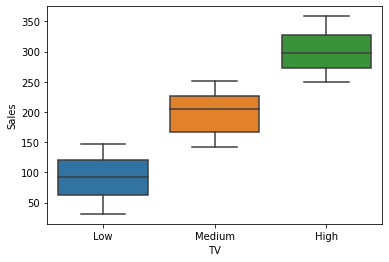

In [5]:
sns.boxplot(data=data, x="TV", y="Sales")
plt.show()

Now, lets make a boxplot to determine how `Sales` vary based on the `Influencer` size category.

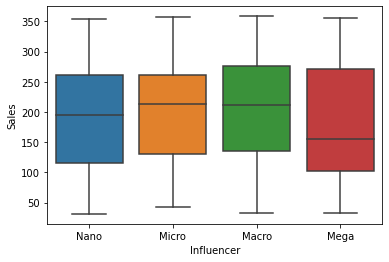

In [6]:
sns.boxplot(data=data, y="Sales", x="Influencer", order=["Nano", "Micro", "Macro", "Mega"])
plt.show()

We can see that there's a significant difference in `Sales` in the `TV` category. The medians and the overall boxplots of `Sales` increase as we increase the `TV` budget. <br>
On the other hand, there's no significant difference in `Sales` in the `Influencer` category. The medians and the overall boxplots of `Sales` more or less remains the same as the type of `Influencer` changes.

Clearly, choosing `TV` over `Influencer` would be a better choice.

Let's clean our dataset by removing any missing values.

In [7]:
data = data.dropna()
data.isna().sum(axis=0)

TV              0
Radio           0
Social Media    0
Influencer      0
Sales           0
dtype: int64

## Creating and fitting a linear regression model

In [8]:
ols_formula = "Sales ~ C(TV)"
OLS = ols(data = data, formula = ols_formula)
model = OLS.fit()

summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1971.
Date:                Sun, 24 Mar 2024   Prob (F-statistic):          8.81e-256
Time:                        10:43:23   Log-Likelihood:                -2778.9
No. Observations:                 569   AIC:                             5564.
Df Residuals:                     566   BIC:                             5577.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         300.5296      2.417    124.360      0.000     295.783     305.276
C(TV)[T.Low]     -208.8133      3.329    -62.720      0.000    -215.353    -202.274
C(TV)[T.Medium]  -101.5061      3.325    -30.526      0.000    -108.038     -94.975
==============================================================================
Omnibus:                      450.714   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.763
Skew:                          -0.044   Prob(JB):                     1.71e-08
Kurtosis:                       1.775   Cond. No.                         3.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking model assumptions

### Model assumption: Linearity

Because your model does not have any continuous independent variables, the linearity assumption is not required.

### Model assumption: Independence

The independent observation assumption states that each observation in the dataset is independent. As each marketing promotion (row) is independent from one another, the independence assumption is not violated.

### Model assumption: Normality

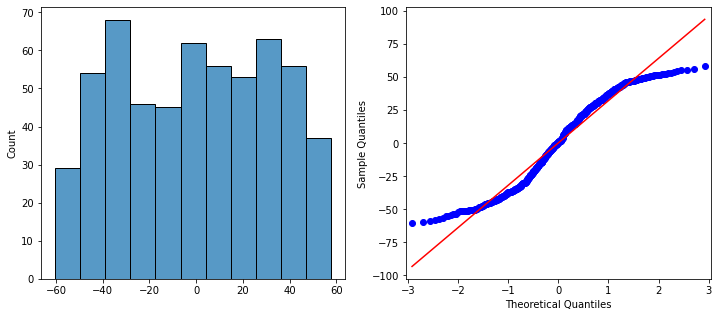

In [9]:
import statsmodels.api as sm

fig, axes = plt.subplots(1, 2, figsize=(12,5))
residuals = model.resid
sns.histplot(residuals, ax=axes[0])

sm.qqplot(residuals, line='s', ax=axes[1])
plt.show()

There is reasonable concern that the normality assumption is not met when TV is used as the independent variable predicting Sales. The normal q-q forms an 'S' that deviates off the red diagonal line, which is not desired behavior. This kind of thing really needs to be communicated/conveyed to the stakeholders.

### Model assumption: Homoscedasticity

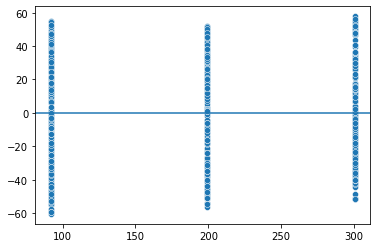

In [10]:
sns.scatterplot(y=residuals, x=model.predict(data["TV"]))
plt.axhline(y=0)
plt.show()

The variance where there are fitted values is similarly distributed, validating that the constant variance assumption is met.

## Results

In [11]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1971.
Date:                Sun, 24 Mar 2024   Prob (F-statistic):          8.81e-256
Time:                        10:43:23   Log-Likelihood:                -2778.9
No. Observations:                 569   AIC:                             5564.
Df Residuals:                     566   BIC:                             5577.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         300.5296      2.417    124.360      0.000     295.783     305.276
C(TV)[T.Low]     -208.8133      3.329    -62.720      0.000    -215.353    -202.274
C(TV)[T.Medium]  -101.5061      3.325    -30.526      0.000    -108.038     -94.975
==============================================================================
Omnibus:                      450.714   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.763
Skew:                          -0.044   Prob(JB):                     1.71e-08
Kurtosis:                       1.775   Cond. No.                         3.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Relation:** Using `TV` as the independent variable results in a linear regression model with $𝑅^2=0.874$. In other words, the model explains $87.4%$ of the variation in `Sales`. This makes the model an effective predictor of `Sales`.

**Observations:** The default `TV` category for the model is `High`, because there are coefficients for the other two `TV` categories, `Medium` and `Low`. According to the model, `Sales` with a `Medium` or `Low` `TV` category are lower on average than `Sales` with a `High` `TV` category. For example, the model predicts that a `Low` `TV` promotion would be 208.813 (in millions of dollars) lower in Sales on average than a `High` `TV` promotion.

**Uncertainity:** The p-value for all coefficients is $0.000$, meaning all coefficients are statistically significant at $p=0.05$. The 95% confidence intervals for each coefficient should be reported when presenting results to stakeholders. For instance, there is a $95\%$ chance the interval $[-215.353,-202.274]$ contains the true parameter of the slope of $\beta_{TVLow}$, which is the estimated difference in promotion sales when a `Low` `TV` promotion is chosen instead of a `High` `TV` promotion.

## Performing a one-way ANOVA test

In [12]:
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(TV),2.0,4.052692e+06,2.026346e+06,1971.455737,8.805550e-256
Residual,566.0,5.817589e+05,1.027843e+03,NaN,NaN


$H_0$: There is no difference in `Sales` based on the `TV` promotion budget. <br>
$H_A$: There is a difference in `Sales` based on the `TV` promotion budget.

The F-test statistic is 1971.46 and the p-value is $8.81 * 10^{-256}$ (i.e., very small). Because the p-value is less than 0.05, we would reject the null hypothesis that there is no difference in `Sales` based on the `TV` promotion budget. <br>
**Conclusion:** The results of the one-way ANOVA test indicate that you can reject the null hypothesis in favor of the alternative hypothesis. There is a statistically significant difference in `Sales` among `TV` groups.

## Performing an ANOVA post hoc test
We will run the Tukey’s HSD post hoc test to compare if there is a significant difference between each pair of categories for TV.

In [13]:
tukey_oneway = pairwise_tukeyhsd(endog = data["Sales"], groups = data["TV"], alpha=0.05)
tukey_oneway.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
High,Low,-208.8133,0.001,-216.637,-200.9896,True
High,Medium,-101.5061,0.001,-109.3204,-93.6918,True
Low,Medium,107.3072,0.001,99.7063,114.908,True


The first row, which compares the `High` and `Low` `TV` groups, indicates that we can reject the null hypothesis that there is no significant difference between the `Sales` of these two groups.

We can also reject the null hypotheses for the two other pairwise comparisons that compare `High` to `Medium` and `Low` to `Medium`.

A post hoc test was conducted to determine which `TV` groups are different and how many are different from each other. This provides more detail than the one-way ANOVA results, which can at most determine that at least one group is different. Further, using the Tukey HSD controls for the increasing probability of incorrectly rejecting a null hypothesis from peforming multiple tests. 

The results were that `Sales` is not the same between any pair of `TV` groups. 